In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision.models import convnext_base, convnext_tiny
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss, mean_squared_error, mean_absolute_error, r2_score
import csv
import torch.nn.functional as F

### Read the two metadata files and concatenate them to form one metadata file.

In [2]:
# Load the metadata
metadata_cafe1 = pd.read_csv('nutrition5k_dataset/metadata/dish_metadata_cafe1.csv', sep=",", header=None, low_memory=False)
metadata_cafe2 = pd.read_csv('nutrition5k_dataset/metadata/dish_metadata_cafe2.csv', sep=",", header=None, low_memory=False)

# Combine the metadata
metadata = pd.concat([metadata_cafe1, metadata_cafe2], ignore_index=True)

print(metadata_cafe1.shape)
print(metadata_cafe2.shape)

(4768, 244)
(238, 153)


### Create a dataframe containing all the image paths (nutrition5k_dataset/imagery/realsense_overhead/dish_XXXXXXXXXX/rbg.png). 
### Merge this into the metadata dataframe to create a merged_data dataframe.

In [3]:
# Define the path to the imagery folder
image_base_path = 'nutrition5k_dataset/imagery/realsense_overhead/'

# Get all dish_ids from the imagery folder
image_paths = []
dish_ids = []
for root, dirs, files in os.walk(image_base_path):
    for file in files:
        if file == 'rgb.png':
            full_path = os.path.join(root, file)
            image_paths.append(full_path)
            dish_id = os.path.basename(root)  # Extract the dish_id
            dish_ids.append(dish_id)

# Create a DataFrame for the image paths and dish_ids
image_df = pd.DataFrame({
    'dish_id': dish_ids,
    'image_path': image_paths
})

# Rename the first column to 'dish_id' for clarity
metadata = metadata.rename(columns={metadata.columns[0]: 'dish_id'})

In [4]:
image_df.head()

,dish_id,image_path
0,dish_1565379827,nutrition5k_dataset/imagery/realsense_overhead...
1,dish_1563468269,nutrition5k_dataset/imagery/realsense_overhead...
2,dish_1563389786,nutrition5k_dataset/imagery/realsense_overhead...
3,dish_1561662458,nutrition5k_dataset/imagery/realsense_overhead...
4,dish_1559593794,nutrition5k_dataset/imagery/realsense_overhead...


### Preprocess the images for training with Swin Transformer. Images were loaded with PIL and need to be converted to RGB format, resized, and normalized.

In [5]:
# Define the image preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Function to load and preprocess an image
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    return image

### Create a tensor for the labels. Merge the metadata and image dataframes to form one frame.

In [6]:
nutritional_columns = [1, 2, 3, 4, 5]  # Adjust these indices based on your data
labels = metadata.iloc[:, nutritional_columns].values

# Convert labels to torch tensors
labels = torch.tensor(labels, dtype=torch.float32)

# Assuming dish_id is in column 0, merge with the image data
merged_data = pd.merge(left=metadata, right=image_df, how="inner", left_on="dish_id", right_on='dish_id')
print(merged_data.shape)
merged_data.head()

(3490, 245)


,dish_id,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,image_path
0,dish_1561662216,300.794281,193,12.387489,28.218290,18.633970,ingr_0000000508,soy sauce,3.398568,1.801241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nutrition5k_dataset/imagery/realsense_overhead...
1,dish_1561662054,419.438782,292,23.838249,26.351543,25.910593,ingr_0000000312,pepper,0.300716,0.120286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nutrition5k_dataset/imagery/realsense_overhead...
2,dish_1562008979,382.936646,290,22.224644,10.173570,35.345387,ingr_0000000448,jalapenos,0.192961,0.055959,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nutrition5k_dataset/imagery/realsense_overhead...
3,dish_1560455030,20.590000,103,0.148000,4.625000,0.956000,ingr_0000000471,cherry tomatoes,55.000000,9.900000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nutrition5k_dataset/imagery/realsense_overhead...
4,dish_1558372433,74.360001,143,0.286000,0.429000,20.020000,ingr_0000000453,deprecated,143.000000,74.360000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nutrition5k_dataset/imagery/realsense_overhead...


### Not all entries in the merged_data dataframe have an associated image. Here, the rows without an image are filtered out.

In [7]:
image_base_path = 'nutrition5k_dataset/imagery/realsense_overhead/'

def image_exists(image_path):
    return os.path.exists(image_path)

merged_data['image_exists'] = merged_data['image_path'].apply(image_exists)

filtered_data = merged_data[merged_data['image_exists'] == True].drop(columns=['image_exists'])
filtered_data.shape

(3490, 245)

### Starting with column 7 out to column 238, are the ingredients names. 

In [8]:
filtered_data.iloc[:,[7,14,21,28,35,42,49,56,63,70,77,84,91,98,105,112,119,126,133]] #

,7,14,21,28,35,42,49,56,63,70,77,84,91,98,105,112,119,126,133
0,soy sauce,garlic,white rice,parsley,onions,brown rice,vinegar,apple,mixed greens,sugar,salt,lemon juice,olive oil,pork,bok choy,pepper,millet,NaN,NaN
1,pepper,white rice,mixed greens,garlic,soy sauce,millet,lemon juice,bok choy,olive oil,onions,vinegar,green beans,pork,apple,sugar,salt,parsley,NaN,NaN
2,jalapenos,lemon juice,pork,wheat berry,cabbage,pepper,salt,carrot,garlic,caesar salad,olive oil,parsley,mayonnaise,NaN,NaN,NaN,NaN,NaN,NaN
3,cherry tomatoes,cucumbers,baby carrots,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,deprecated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3485,cucumbers,celery,carrot,onions,apple cider,vinegar,broth,salt,pork,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3486,strawberries,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3487,broccoli,olive oil,bread crumbs,salt,jalapenos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3488,scrambled eggs,roasted potatoes,crepes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Create a column in the filtered_data dataframe with a list of the unique ingredients for each row, all together. 

In [9]:
# Identify the columns related to ingredients
ingredient_columns = metadata.columns[6:]  # Ingredients start from column 6

# Function to parse ingredients for each dish
def parse_ingredients(row):
    ingredients = []
    # The first 6 columns are: dish_id (0), total_calories (1), total_mass (2), total_fat (3), total_carb (4), total_protein (5)
    num_ingredients = (len(row) - 6) // 7  # Each ingredient spans 7 columns
    for i in range(num_ingredients):
        idx = 6 + i * 7  # Starting index for each ingredient
        ingr_id = row[idx]
        ingr_name = row[idx + 1]
        ingr_grams = row[idx + 2]
        ingr_calories = row[idx + 3]
        ingr_fat = row[idx + 4]
        ingr_carb = row[idx + 5]
        ingr_protein = row[idx + 6]

        if pd.isna(ingr_name):
            continue  # Skip if ingredient name is NaN

        ingredients.append({
            'ingr_id': ingr_id,
            'ingr_name': str(ingr_name).strip().lower(),
            'ingr_grams': ingr_grams,
            'ingr_calories': ingr_calories,
            'ingr_fat': ingr_fat,
            'ingr_carb': ingr_carb,
            'ingr_protein': ingr_protein
        })
    return ingredients

# Apply the function to each row in filtered_data
filtered_data['ingredients'] = filtered_data.apply(parse_ingredients, axis=1)

### Read in the glycemic index data from the Excel spreadsheet. Create a dictionary to reference later.

In [10]:
# Load glycemic index data
glycemic_data = pd.read_excel('glycemic_index.xlsx')

# Clean ingredient names in glycemic data for consistent matching
glycemic_data['Item'] = glycemic_data['Item'].str.strip().str.lower()

# Create a mapping from ingredient name to glycemic index
glycemic_index_dict = glycemic_data.set_index('Item')['Glycemic index'].to_dict()

### From the list of ingredients and their masses, we can calculate the total glycemic index of the dish.

In [11]:
def calculate_weighted_gi(ingredients):
    total_mass = 0
    weighted_gi_sum = 0
    for ingr in ingredients:
        ingr_name = ingr['ingr_name']
        ingr_mass = ingr['ingr_grams']
        try:
            gi = glycemic_index_dict.get(ingr_name, None)
            if gi is not None and not pd.isna(ingr_mass):
                total_mass += ingr_mass
                weighted_gi_sum += gi * ingr_mass
        except KeyError:
            # Ingredient not found in glycemic index, skip or handle accordingly
            continue
    if total_mass > 0:
        weighted_gi = weighted_gi_sum / total_mass
    else:
        weighted_gi = np.nan  # Assign NaN if total_mass is zero
    return weighted_gi

# Apply the function to each dish
filtered_data['weighted_gi'] = filtered_data['ingredients'].apply(calculate_weighted_gi)

### I want to exclude some ingredients from the training loop. First read in the file of ingredients to be excluded.

In [12]:
# Read excluded ingredients from file
with open('excluded_ingredients.txt', 'r') as file:
    excluded_ingredients = [line.strip().lower() for line in file if line.strip()]

def extract_ingredient_names(ingredients_list):
    # Extract ingredient names, excluding the ones in the excluded list
    ingredient_names = [
        ingr['ingr_name'].lower() for ingr in ingredients_list
        if ingr['ingr_name'].lower() not in excluded_ingredients
    ]
    return ingredient_names

### Define NutritionDataset, which will collect the nutritional labels, ingredient labels, the weighted glycemic index. The ingredient list will be label binarized for training. 

In [13]:
class NutritionDataset(Dataset):
    def __init__(self, data, transform=None, all_ingredients=None, encoder=None):
        self.data = data.reset_index(drop=True)
        self.transform = transform

        # Use the provided all_ingredients and encoder
        self.all_ingredients = all_ingredients
        self.encoder = encoder

        # Ensure all_ingredients and encoder are provided
        if self.all_ingredients is None or self.encoder is None:
            raise ValueError("all_ingredients and encoder must be provided")

        # Extract and binarize ingredient labels, excluding the specified ingredients
        ingredient_lists = self.data['ingredients'].apply(extract_ingredient_names)
        self.data['ingredient_labels'] = ingredient_lists.apply(self.binarize_ingredients)

        # **Insert the code here to remove samples with empty ingredient labels**
        # Identify rows with non-empty ingredient labels
        non_empty_indices = self.data['ingredient_labels'].apply(lambda x: x.sum() > 0)

        # Filter the data to include only samples with non-empty ingredient labels
        self.data = self.data[non_empty_indices].reset_index(drop=True)

    def binarize_ingredients(self, ingredients):
        labels = np.zeros(len(self.all_ingredients), dtype=np.float32)
        valid_ingredients = [ingr for ingr in ingredients if ingr in self.encoder.classes_]
        if valid_ingredients:
            indices = self.encoder.transform(valid_ingredients)
            labels[indices] = 1.0
        return labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load image
        img_path = self.data.iloc[idx]['image_path']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Get nutritional labels (adjust indices if necessary)
        nutritional_columns = [1, 2, 3, 4, 5]  # Make sure these are correct
        nutritional_values = self.data.iloc[idx][nutritional_columns].values.astype(np.float32)

        # Get ingredient labels and weighted GI
        ingredient_labels = self.data.iloc[idx]['ingredient_labels']
        weighted_gi = self.data.iloc[idx]['weighted_gi']

        if pd.isna(weighted_gi):
            weighted_gi = 0.0  # Handle missing values as appropriate
        weighted_gi = np.array([weighted_gi], dtype=np.float32)

        # **Optional safeguard**
        if ingredient_labels.sum() == 0:
            raise ValueError(f"Sample at index {idx} has empty ingredient labels.")

        # Create label dictionary
        labels = {
            'nutritional_labels': torch.tensor(nutritional_values),
            'ingredient_labels': torch.tensor(ingredient_labels),
            'weighted_gi': torch.tensor(weighted_gi)
        }

        return image, labels

### Split the data into train, validation and test sets. Create the dataloaders.

In [14]:
# Recompute all_ingredients from the filtered ingredient lists
all_ingredients_set = set()

for ingredients_list in filtered_data['ingredients']:
    ingredient_names = extract_ingredient_names(ingredients_list)
    all_ingredients_set.update(ingredient_names)

all_ingredients = sorted(list(all_ingredients_set))

# Initialize the LabelEncoder
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(all_ingredients)

LabelEncoder()

### Create train, validation and test datasets. Set batch_size. Create the dataloaders.

In [15]:
# Split the data
train_data, test_data = train_test_split(filtered_data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Create datasets using the shared all_ingredients and encoder
train_dataset = NutritionDataset(train_data, transform=transform, all_ingredients=all_ingredients, encoder=encoder)
val_dataset = NutritionDataset(val_data, transform=transform, all_ingredients=all_ingredients, encoder=encoder)
test_dataset = NutritionDataset(test_data, transform=transform, all_ingredients=all_ingredients, encoder=encoder)

batch_size = 32  # Adjust based on your GPU memory

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

### Calculate the total number of unique ingredients, minus the excluded ingredients.

In [16]:
# Recompute ingredient counts
ingredient_counts = np.zeros(len(encoder.classes_), dtype=np.float32)
for idx in range(len(train_dataset)):
    _, labels = train_dataset[idx]
    if labels is not None:
        ingredient_counts += labels['ingredient_labels'].numpy()

# Calculate class weights
total_counts = np.sum(ingredient_counts)
class_weights = total_counts / (len(ingredient_counts) * (ingredient_counts + 1e-6))
class_weights = class_weights / np.sum(class_weights) * len(class_weights)
num_ingredients = len(ingredient_counts)

# Convert class weights to tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

In [17]:
print("Columns in train_dataset.data:", train_dataset.data.columns)

Columns in train_dataset.data: Index([          'dish_id',                   1,                   2,
                         3,                   4,                   5,
                         6,                   7,                   8,
                         9,
       ...
                       238,                 239,                 240,
                       241,                 242,                 243,
              'image_path',       'ingredients',       'weighted_gi',
       'ingredient_labels'],
      dtype='object', length=248)


In [18]:
#%pip install timm
import timm  # Import Swin Transformer models

### Define the model using Swin Transformers.

In [23]:
class MultiTaskSwinTransformer(nn.Module):
    def __init__(self, num_ingredients):
        super(MultiTaskSwinTransformer, self).__init__()
        self.backbone = timm.create_model('swin_base_patch4_window12_384.ms_in22k', pretrained=True)
        self.backbone.reset_classifier(0)  # Remove the classification head
        
        num_features = self.backbone.num_features  # Should be 768
        
        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # Task-specific heads
        self.fc_nutrition = nn.Linear(num_features, 5)
        self.fc_ingredients = nn.Linear(num_features, num_ingredients)
        self.fc_weighted_gi = nn.Linear(num_features, 1)
    
    def forward(self, x):
        x = self.backbone.forward_features(x)
        
        # Permute dimensions to [batch_size, 768, 7, 7]
        x = x.permute(0, 3, 1, 2)
        
        # Global Average Pooling
        x = self.global_pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Task-specific outputs
        nutrition_output = self.fc_nutrition(x)                   # Output shape: [batch_size, 5]
        ingredient_output = torch.sigmoid(self.fc_ingredients(x)) # Output shape: [batch_size, num_ingredients]
        weighted_gi_output = self.fc_weighted_gi(x)               # Output shape: [batch_size, 1]
        
        return nutrition_output, ingredient_output, weighted_gi_output
        
# Number of ingredient classes
num_ingredient_classes = len(encoder.classes_)  # Assuming `encoder` is defined

# Instantiate the model
model = MultiTaskSwinTransformer(num_ingredient_classes).to(device)
model = model.to(device)

model.safetensors:   0%|          | 0.00/451M [00:00<?, ?B/s]

### Implement adjusting the loss function with class weights. First, calculate the class weights.

In [24]:
# Calculate class weights
total_counts = np.sum(ingredient_counts)
class_weights = total_counts / (len(ingredient_counts) * (ingredient_counts + 1e-6))  # Add epsilon to avoid division by zero
class_weights = class_weights / np.sum(class_weights) * len(class_weights)            # Normalize class weights 
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)    # Convert the weights array into a PyTorch tensor

### Define the loss functions. Set the optimizer and use a LR scheduler. 

In [25]:
# Loss functions
criterion_nutrition = nn.MSELoss()
criterion_ingredients = nn.BCELoss(weight=class_weights_tensor)
criterion_weighted_gi = nn.MSELoss()

# Optimizer
learning_rate = 1e-4  # Adjust as needed
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define learning rate scheduler (optional)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

### Train the model.

In [31]:
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss, mean_absolute_error, mean_squared_error, r2_score
import numpy as np

metrics_list = []

# Initialize lists or DataFrames to store metrics
metrics_df = pd.DataFrame(columns=[
    'epoch', 'train_loss', 'val_loss',
    'train_nutrition_loss', 'val_nutrition_loss',
    'train_ingredient_loss', 'val_ingredient_loss',
    'train_gi_loss', 'val_gi_loss',
    'ingredient_precision', 'ingredient_recall', 'ingredient_f1', 'ingredient_hamming_loss',
    'nutrition_mae', 'nutrition_rmse', 'nutrition_r2',
    'gi_mae', 'gi_rmse', 'gi_r2'
])

num_epochs = 10

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_nutrition_loss = 0.0
    total_ingredient_loss = 0.0
    total_gi_loss = 0.0
    total_samples = 0

    print(f"Starting training epoch: {epoch+1}/{num_epochs}")
    for images, labels in tqdm(train_loader, desc="Training", unit="batch"):
        # Move data to device
        images = images.to(device)
        nutritional_labels = labels['nutritional_labels'].to(device)
        ingredient_labels = labels['ingredient_labels'].to(device)
        weighted_gi_labels = labels['weighted_gi'].to(device)
        batch_size = images.size(0)
        total_samples += batch_size

        optimizer.zero_grad()

        # Forward pass
        nutrition_output, ingredient_output, weighted_gi_output = model(images)

        # Calculate losses
        loss_nutrition = criterion_nutrition(nutrition_output, nutritional_labels)
        loss_ingredients = criterion_ingredients(ingredient_output, ingredient_labels)
        loss_weighted_gi = criterion_weighted_gi(weighted_gi_output, weighted_gi_labels)

        # Combine losses
        total_loss = loss_nutrition + loss_ingredients + loss_weighted_gi

        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()

        # Accumulate losses
        running_loss += total_loss.item() * batch_size
        total_nutrition_loss += loss_nutrition.item() * batch_size
        total_ingredient_loss += loss_ingredients.item() * batch_size
        total_gi_loss += loss_weighted_gi.item() * batch_size

    # Calculate average training losses
    avg_train_loss = running_loss / total_samples
    avg_train_nutrition_loss = total_nutrition_loss / total_samples
    avg_train_ingredient_loss = total_ingredient_loss / total_samples
    avg_train_gi_loss = total_gi_loss / total_samples

    # VALIDATION LOOP ==============================================
    model.eval()
    val_loss = 0.0
    val_nutrition_loss = 0.0
    val_ingredient_loss = 0.0
    val_gi_loss = 0.0
    total_val_samples = 0

    ingredients_true = []
    ingredients_pred = []

    nutrition_true = []
    nutrition_pred = []

    gi_true = []
    gi_pred = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            nutritional_labels = labels['nutritional_labels'].to(device)
            ingredient_labels = labels['ingredient_labels'].to(device)
            weighted_gi_labels = labels['weighted_gi'].to(device)

            # Forward pass
            nutrition_output, ingredient_output, weighted_gi_output = model(images)

            # Move tensors to CPU and convert to numpy arrays
            # Ingredients
            true_ingredient_labels = ingredient_labels.cpu().numpy()
            predicted_ingredient_probs = ingredient_output.cpu().numpy()
            threshold = 0.5  # Adjust if necessary
            predicted_ingredient_labels = (predicted_ingredient_probs >= threshold).astype(int)

            ingredients_true.append(true_ingredient_labels)
            ingredients_pred.append(predicted_ingredient_labels)

            # Nutritional outputs
            true_nutritional_labels = nutritional_labels.cpu().numpy()
            predicted_nutritional_outputs = nutrition_output.cpu().numpy()

            nutrition_true.append(true_nutritional_labels)
            nutrition_pred.append(predicted_nutritional_outputs)

            # Weighted GI
            true_weighted_gi_labels = weighted_gi_labels.cpu().numpy()
            predicted_weighted_gi_outputs = weighted_gi_output.cpu().numpy()

            gi_true.append(true_weighted_gi_labels)
            gi_pred.append(predicted_weighted_gi_outputs)

            batch_size = images.size(0)
            total_val_samples += batch_size

            # Accumulate losses
            val_loss += total_loss.item() * batch_size
            val_nutrition_loss += loss_nutrition.item() * batch_size
            val_ingredient_loss += loss_ingredients.item() * batch_size
            val_gi_loss += loss_weighted_gi.item() * batch_size

    # Calculate average losses per sample
    avg_val_loss = val_loss / total_val_samples
    avg_val_nutrition_loss = val_nutrition_loss / total_val_samples
    avg_val_ingredient_loss = val_ingredient_loss / total_val_samples
    avg_val_gi_loss = val_gi_loss / total_val_samples    
    
    # Concatenate accumulated arrays
    ingredients_true = np.vstack(ingredients_true)
    ingredients_pred = np.vstack(ingredients_pred)
    nutrition_true = np.vstack(nutrition_true)
    nutrition_pred = np.vstack(nutrition_pred)
    gi_true = np.vstack(gi_true)
    gi_pred = np.vstack(gi_pred)

    # Compute metrics
    ingredient_precision = precision_score(ingredients_true, ingredients_pred, average='micro', zero_division=0)
    ingredient_recall = recall_score(ingredients_true, ingredients_pred, average='micro', zero_division=0)
    ingredient_f1 = f1_score(ingredients_true, ingredients_pred, average='micro', zero_division=0)
    ingredient_hamming = hamming_loss(ingredients_true, ingredients_pred)

    nutrition_mae = mean_absolute_error(nutrition_true, nutrition_pred)
    nutrition_rmse = np.sqrt(mean_squared_error(nutrition_true, nutrition_pred))
    nutrition_r2 = r2_score(nutrition_true, nutrition_pred, multioutput='variance_weighted')

    gi_mae = mean_absolute_error(gi_true, gi_pred)
    gi_rmse = np.sqrt(mean_squared_error(gi_true, gi_pred))
    gi_r2 = r2_score(gi_true, gi_pred)

    metrics_list.append({
    'epoch': epoch + 1,
    'train_loss': avg_train_loss,
    'val_loss': avg_val_loss,
    'train_nutrition_loss': avg_train_nutrition_loss,
    'val_nutrition_loss': avg_val_nutrition_loss,
    'train_ingredient_loss': avg_train_ingredient_loss,
    'val_ingredient_loss': avg_val_ingredient_loss,
    'train_gi_loss': avg_train_gi_loss,
    'val_gi_loss': avg_val_gi_loss,
    'ingredient_precision': ingredient_precision,
    'ingredient_recall': ingredient_recall,
    'ingredient_f1': ingredient_f1,
    'ingredient_hamming_loss': ingredient_hamming,
    'nutrition_mae': nutrition_mae,
    'nutrition_rmse': nutrition_rmse,
    'nutrition_r2': nutrition_r2,
    'gi_mae': gi_mae,
    'gi_rmse': gi_rmse,
    'gi_r2': gi_r2
    })
    
    # Print epoch statistics
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
    print(f"Ingredient Precision: {ingredient_precision:.4f}, Recall: {ingredient_recall:.4f}, F1 Score: {ingredient_f1:.4f}, Hamming Loss: {ingredient_hamming:.4f}")
    print(f"Nutrition MAE: {nutrition_mae:.4f}, RMSE: {nutrition_rmse:.4f}, R²: {nutrition_r2:.4f}")
    print(f"GI MAE: {gi_mae:.4f}, RMSE: {gi_rmse:.4f}, R²: {gi_r2:.4f}\n")

    metrics_df = pd.DataFrame(metrics_list)
    
    # Update the learning rate scheduler if you have one
    scheduler.step()

Starting training epoch: 1/10


Training: 100%|██████████████████████████████| 79/79 [19:39<00:00, 14.94s/batch]


Epoch [1/10]
Training Loss: 26206.9832, Validation Loss: 36301.8555
Ingredient Precision: 0.0141, Recall: 0.0020, F1 Score: 0.0035, Hamming Loss: 0.0272
Nutrition MAE: 74.7784, RMSE: 154.4575, R²: -0.6851
GI MAE: 16.1838, RMSE: 20.3098, R²: 0.1637

Starting training epoch: 2/10


Training: 100%|██████████████████████████████| 79/79 [19:43<00:00, 14.98s/batch]


Epoch [2/10]
Training Loss: 24039.9848, Validation Loss: 4151.2002
Ingredient Precision: 0.0047, Recall: 0.0007, F1 Score: 0.0012, Hamming Loss: 0.0272
Nutrition MAE: 70.0395, RMSE: 147.5241, R²: -0.5372
GI MAE: 15.3814, RMSE: 19.4354, R²: 0.2341

Starting training epoch: 3/10


Training: 100%|██████████████████████████████| 79/79 [19:50<00:00, 15.07s/batch]


Epoch [3/10]
Training Loss: 22056.0984, Validation Loss: 22836.3340
Ingredient Precision: 0.0319, Recall: 0.0066, F1 Score: 0.0110, Hamming Loss: 0.0285
Nutrition MAE: 65.7412, RMSE: 141.1914, R²: -0.4080
GI MAE: 14.5761, RMSE: 18.8387, R²: 0.2804

Starting training epoch: 4/10


Training: 100%|██████████████████████████████| 79/79 [19:53<00:00, 15.11s/batch]


Epoch [4/10]
Training Loss: 20301.1626, Validation Loss: 21441.2656
Ingredient Precision: 0.0390, Recall: 0.0053, F1 Score: 0.0094, Hamming Loss: 0.0269
Nutrition MAE: 62.6944, RMSE: 135.4612, R²: -0.2961
GI MAE: 13.0507, RMSE: 17.3314, R²: 0.3910

Starting training epoch: 5/10


Training: 100%|██████████████████████████████| 79/79 [19:40<00:00, 14.95s/batch]


Epoch [5/10]
Training Loss: 18731.7105, Validation Loss: 10678.0879
Ingredient Precision: 0.0323, Recall: 0.0027, F1 Score: 0.0049, Hamming Loss: 0.0257
Nutrition MAE: 59.4890, RMSE: 129.5210, R²: -0.1849
GI MAE: 13.7073, RMSE: 18.5872, R²: 0.2995

Starting training epoch: 6/10


Training: 100%|██████████████████████████████| 79/79 [19:42<00:00, 14.97s/batch]


Epoch [6/10]
Training Loss: 17780.8162, Validation Loss: 14230.0908
Ingredient Precision: 0.0419, Recall: 0.0053, F1 Score: 0.0094, Hamming Loss: 0.0267
Nutrition MAE: 57.9750, RMSE: 128.7024, R²: -0.1700
GI MAE: 12.6146, RMSE: 17.0240, R²: 0.4124

Starting training epoch: 7/10


Training: 100%|██████████████████████████████| 79/79 [19:41<00:00, 14.95s/batch]


Epoch [7/10]
Training Loss: 17587.6929, Validation Loss: 15988.2852
Ingredient Precision: 0.0244, Recall: 0.0047, F1 Score: 0.0078, Hamming Loss: 0.0282
Nutrition MAE: 57.3763, RMSE: 128.1455, R²: -0.1599
GI MAE: 12.2399, RMSE: 16.7488, R²: 0.4312

Starting training epoch: 8/10


Training: 100%|██████████████████████████████| 79/79 [19:47<00:00, 15.03s/batch]


Epoch [8/10]
Training Loss: 17422.3515, Validation Loss: 38083.5156
Ingredient Precision: 0.0373, Recall: 0.0066, F1 Score: 0.0113, Hamming Loss: 0.0278
Nutrition MAE: 57.0351, RMSE: 127.4983, R²: -0.1482
GI MAE: 12.1989, RMSE: 16.6491, R²: 0.4380

Starting training epoch: 9/10


Training: 100%|██████████████████████████████| 79/79 [19:45<00:00, 15.01s/batch]


Epoch [9/10]
Training Loss: 17259.6456, Validation Loss: 10790.9678
Ingredient Precision: 0.0366, Recall: 0.0066, F1 Score: 0.0112, Hamming Loss: 0.0279
Nutrition MAE: 56.6349, RMSE: 126.9227, R²: -0.1378
GI MAE: 12.1253, RMSE: 16.6287, R²: 0.4394

Starting training epoch: 10/10


Training: 100%|██████████████████████████████| 79/79 [19:43<00:00, 14.98s/batch]


Epoch [10/10]
Training Loss: 17101.3218, Validation Loss: 17349.4727
Ingredient Precision: 0.0353, Recall: 0.0060, F1 Score: 0.0102, Hamming Loss: 0.0277
Nutrition MAE: 56.3689, RMSE: 126.3476, R²: -0.1275
GI MAE: 12.0868, RMSE: 16.5387, R²: 0.4454



### Save the trained model

In [32]:
torch.save(model.state_dict(), 'nutrition_model_11-24.pth')

### Or, load a trained model, if available

In [ ]:
model = NutritionModel(num_ingredients)
model.load_state_dict(torch.load('nutrition_model_11-24.pth'))
model = model.to(device)

### Plot the training and validation loss curves

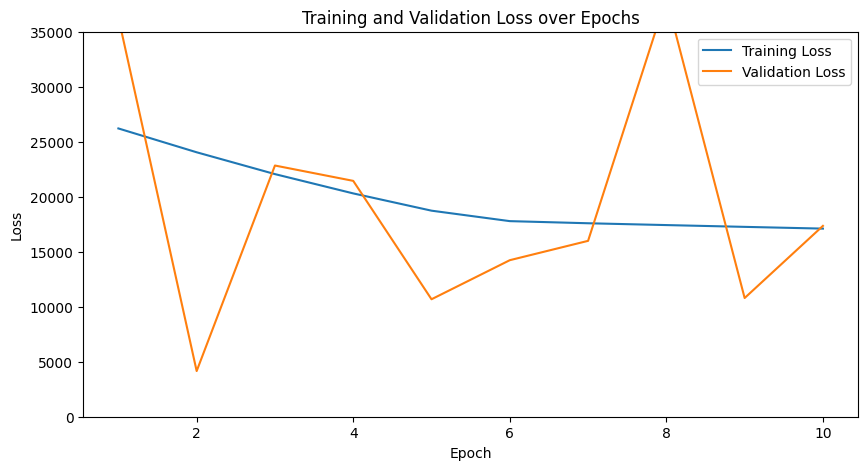

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.ylim(0,35000)
plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Training Loss')
plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Calculate stats

In [34]:
# Concatenate accumulated arrays
ingredients_true = np.vstack(ingredients_true)
ingredients_pred = np.vstack(ingredients_pred)

nutrition_true = np.vstack(nutrition_true)
nutrition_pred = np.vstack(nutrition_pred)

gi_true = np.vstack(gi_true)
gi_pred = np.vstack(gi_pred)

# Compute Classification Metrics for Ingredients
ingredient_precision = precision_score(ingredients_true, ingredients_pred, average='samples', zero_division=0)
ingredient_recall = recall_score(ingredients_true, ingredients_pred, average='samples', zero_division=0)
ingredient_f1 = f1_score(ingredients_true, ingredients_pred, average='samples', zero_division=0)
ingredient_hamming_loss = hamming_loss(ingredients_true, ingredients_pred)

# Compute Regression Metrics for Nutritional Information
nutrition_mae = mean_absolute_error(nutrition_true, nutrition_pred)
nutrition_mse = mean_squared_error(nutrition_true, nutrition_pred)
nutrition_rmse = np.sqrt(nutrition_mse)
nutrition_r2 = r2_score(nutrition_true, nutrition_pred, multioutput='variance_weighted')

# Compute Regression Metrics for Weighted GI
gi_mae = mean_absolute_error(gi_true, gi_pred)
gi_mse = mean_squared_error(gi_true, gi_pred)
gi_rmse = np.sqrt(gi_mse)
gi_r2 = r2_score(gi_true, gi_pred)

print(f"Validation Results for Epoch {epoch+1}/{num_epochs}:")
print(f"Total Loss: {avg_val_loss:.4f}")
print(f"Nutritional Loss: {avg_val_nutrition_loss:.4f}")
print(f"Ingredient Loss: {avg_val_ingredient_loss:.4f}")
print(f"Weighted GI Loss: {avg_gi_loss:.4f}\n")

print("Ingredient Prediction Metrics:")
print(f"Precision: {ingredient_precision:.4f}")
print(f"Recall: {ingredient_recall:.4f}")
print(f"F1 Score: {ingredient_f1:.4f}")
print(f"Hamming Loss: {ingredient_hamming_loss:.4f}\n")

print("Nutritional Information Regression Metrics:")
print(f"MAE: {nutrition_mae:.4f}")
print(f"MSE: {nutrition_mse:.4f}")
print(f"RMSE: {nutrition_rmse:.4f}")
print(f"R² Score: {nutrition_r2:.4f}\n")

print("Weighted Glycemic Index Regression Metrics:")
print(f"MAE: {gi_mae:.4f}")
print(f"MSE: {gi_mse:.4f}")
print(f"RMSE: {gi_rmse:.4f}")
print(f"R² Score: {gi_r2:.4f}")

Validation Results for Epoch 10/10:
Total Loss: 17349.4727
Nutritional Loss: 17153.2969
Ingredient Loss: 0.0098
Weighted GI Loss: 211.8660

Ingredient Prediction Metrics:
Precision: 0.0136
Recall: 0.0116
F1 Score: 0.0074
Hamming Loss: 0.0277

Nutritional Information Regression Metrics:
MAE: 56.3689
MSE: 15963.7090
RMSE: 126.3476
R² Score: -0.1275

Weighted Glycemic Index Regression Metrics:
MAE: 12.0868
MSE: 273.5302
RMSE: 16.5387
R² Score: 0.4454


### Make predictions on the test dataset

In [35]:
# Testing loop
model.eval()
test_loss = 0.0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        nutritional_labels = labels['nutritional_labels'].to(device)
        ingredient_labels = labels['ingredient_labels'].to(device)
        weighted_gi_labels = labels['weighted_gi'].to(device)

        # Forward pass
        nutrition_output, ingredient_output, weighted_gi_output = model(images)

        # Calculate losses
        loss_nutrition = criterion_nutrition(nutrition_output, nutritional_labels)
        loss_ingredients = criterion_ingredients(ingredient_output, ingredient_labels)
        loss_weighted_gi = criterion_weighted_gi(weighted_gi_output, weighted_gi_labels)

        total_loss = loss_nutrition + loss_ingredients + loss_weighted_gi
        test_loss += total_loss.item()

    # Print test statistics
    print(f'Test Loss: {test_loss/len(test_loader):.4f}')

Test Loss: 14730.5273


In [36]:
#%pip install -q ipywidgets
import ipywidgets as widgets
from IPython.display import display, clear_output

### Select a dish and see the prediction

In [39]:
dish_ids = test_dataset.data['dish_id'].tolist()
image_paths = test_dataset.data['image_path'].tolist()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the transform
transform = transforms.Compose([
    transforms.Resize((384, 384)),  # Resize to match model's expected input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet's mean and std
                         std=[0.229, 0.224, 0.225])
])

# Extract image paths and dish IDs from test_dataset
dish_ids = test_dataset.data['dish_id'].tolist()
image_paths = test_dataset.data['image_path'].tolist()

# Create unique dropdown options
dropdown_options = [(f'{dish_id} ({idx})', image_path) 
                    for idx, (dish_id, image_path) in enumerate(zip(dish_ids, image_paths))]

# Define custom widths
dropdown_layout = widgets.Layout(width='400px')  # Adjust the overall width of the dropdown
dropdown_style = {'description_width': '150px'}  # Adjust the width of the label (caption)

# Create the dropdown widget with custom layout and style
image_selector = widgets.Dropdown(
    options=dropdown_options,
    description='Select Image:',
    layout=dropdown_layout,
    style=dropdown_style
)

# Create an output widget with a custom layout
out = widgets.Output(layout={'border': '1px solid black', 'width': '600px'})

def on_select_image(change):
    with out:
        clear_output(wait=True)
        image_path = change['new']
        
        try:
            # Load the image
            image = Image.open(image_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {e}")
            return
        
        # Preprocess the image
        input_image = transform(image).unsqueeze(0).to(device)
        
        # Make predictions
        with torch.no_grad():
            nutrition_output, ingredient_output, weighted_gi_output = model(input_image)
        
        # Process outputs
        nutrition_output = nutrition_output.cpu().numpy().squeeze(0)
        weighted_gi = weighted_gi_output.item()
        
        ingredient_probs = ingredient_output.cpu().numpy().squeeze(0)
        threshold = 0.3                                                       # Adjust this threshold based on your validation results
        predicted_indices = np.where(ingredient_probs >= threshold)[0]
        predicted_ingredients = encoder.inverse_transform(predicted_indices)
        
        # Display the image
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.axis('off')
        plt.title('Selected Image')
        plt.show()
        
        # Display predictions
        print("Predicted Ingredients:")
        for ingredient in predicted_ingredients:
            print(f"- {ingredient}")
        
        total_calories, total_mass, total_fat, total_carb, total_protein = nutrition_output
        
        print("\nNutritional Information:")
        print(f"Total Calories: {total_calories:.2f} kcal")
        print(f"Total Mass: {total_mass:.2f} grams")
        print(f"Total Fat: {total_fat:.2f} grams")
        print(f"Total Carbohydrates: {total_carb:.2f} grams")
        print(f"Total Protein: {total_protein:.2f} grams")
        
        print(f"\nWeighted Glycemic Index: {weighted_gi:.2f}")

# Attach the handler to the dropdown
image_selector.observe(on_select_image, names='value')

# Display the dropdown and output widget
display(image_selector, out)

# Manually call the handler to display predictions for the first image
if dropdown_options:
    initial_image_path = dropdown_options[0][1]
    on_select_image({'new': initial_image_path})

Dropdown(description='Select Image:', layout=Layout(width='400px'), options=(('dish_1558032156 (0)', 'nutritio…

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

In [39]:
ingredient_counts = np.zeros(len(encoder.classes_), dtype=np.float32)

try:
    for idx in range(len(train_dataset)):
        _, labels = train_dataset[idx]
        ingredient_counts += labels['ingredient_labels'].numpy()
    print("Ingredient counts calculated successfully.")
except Exception as e:
    print(f"Error calculating ingredient counts: {e}")

# Assuming 'train_dataset' is your training dataset
ingredient_names = encoder.inverse_transform(np.arange(len(ingredient_counts)))
ingredient_freq = list(zip(ingredient_names, ingredient_counts))
ingredient_freq.sort(key=lambda x: x[1], reverse=True)

# Print the top 10 most frequent ingredients
print("Top 10 Ingredients by Frequency:")
for ingr, count in ingredient_freq[:10]:
    print(f"{ingr}: {count}")

Ingredient counts calculated successfully.
Top 10 Ingredients by Frequency:
garlic: 717.0
onions: 531.0
arugula: 392.0
parsley: 370.0
cherry tomatoes: 368.0
carrot: 327.0
spinach (raw): 318.0
broccoli: 305.0
shallots: 300.0
cucumbers: 264.0


In [ ]:
# Save the model
torch.save(model.state_dict(), 'nutrition_model.pth')

# To load the model later
# model = NutritionModel(num_ingredients)
# model.load_state_dict(torch.load('nutrition_model.pth'))
# model = model.to(device)